# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of prediciting the sale price of bulldozers.

## 1. Problem definition

> How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## 2. Data

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can you it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

**Note:** The goal for most regression metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimizes RMSLE.

## 4. Features

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this, is to create a **data dictionary**.

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. You can [download this file directly from the Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) (account required) or view it on Google Sheets.

With all of this being known, let's get started! 

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [4]:
# Import training and validation sets
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [5]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [6]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

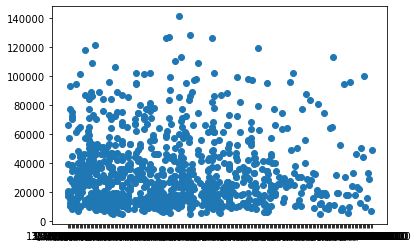

In [7]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df ["SalePrice"][:1000])

In [8]:
df.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

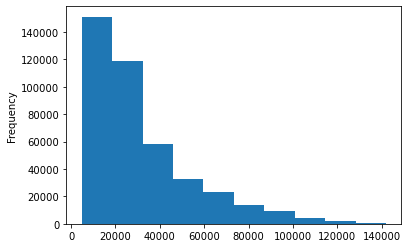

In [9]:
df.SalePrice.plot.hist();

### Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the `parse_dates` parameter.

In [10]:
# Import data again but this time parse dates
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", 
                 low_memory=False, 
                 parse_dates=["saledate"])

In [11]:
df.saledate.dtype

dtype('<M8[ns]')

In [12]:
df.saledate[:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

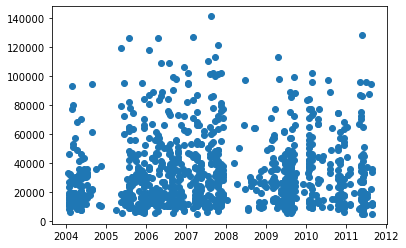

In [15]:
fig, ax = plt.subplots()
ax.scatter(df.saledate[:1000], df.SalePrice[:1000])

In [16]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [19]:
df.saledate.head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.

In [20]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

We make a copy of the original dataframe so when we manipulate the copy, we've still got our original data.

In [22]:
# Make a copy
df_tmp = df.copy()

### Add datetime parameters for `saledate` column (should be done for any timeseries project)

In [28]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [29]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [30]:
# Now we've enriched our DataFrame with date time features, we can remove 'saledate'
df_tmp.drop("saledate", axis=1, inplace=True)

In [31]:
# Check the values of different columns
df_tmp.state.value_counts()

Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virginia   

In [32]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


## 5. Modelling

We've done enough EDA (we could always do more) but let's start to do some model-driven EDA.

In [33]:
# Let's build a machine learning model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1, 
                              random_state=42)

model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

ValueError: could not convert string to float: 'Low'

In [35]:
# columns not changed to numbers yet
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

In [36]:
df_tmp["UsageBand"].dtype

dtype('O')

In [38]:
# Data still has missing values
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Fill missing values

#### Fill numerical missing values first

In [39]:
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [40]:
df_tmp.ModelID

205615     8434
274835    10150
141296     4139
212552     8591
62755      4089
          ...  
410879     5266
412476    19330
411927    17244
407124     3357
409203     4701
Name: ModelID, Length: 412698, dtype: int64

In [42]:
# Check for which mumeric columns have null values
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [44]:
# Fill numeric rows with the median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing or not
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [45]:
# Demonstrate how median is more robust than mean
hundreds = np.full((1000,), 100)
hundreds_billion = np.append(hundreds, 1000000000)
np.mean(hundreds), np.mean(hundreds_billion), np.median(hundreds), np.median(hundreds_billion)

(100.0, 999100.8991008991, 100.0, 100.0)

In [46]:
# Check if there's any null mumeric values
for label, count in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [47]:
# Check to see how many example were missing
df_tmp.auctioneerID_is_missing.value_counts()

False    392562
True      20136
Name: auctioneerID_is_missing, dtype: int64

In [48]:
df_tmp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

#### Filling and turning categorical variables into numbers

In [49]:
# Check for columns which aren't numeric
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [53]:
# Turn categorical variables into numbers and fill missing
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing values
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add +1
        df_tmp[label] = pd.Categorical(content).codes+1

In [52]:
pd.Categorical(df_tmp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [54]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 81.1 MB


In [55]:
df_tmp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [56]:
# No missing values in our data
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that all of our data is numeric as well as our dataframe has no missing values, we should be able to build a machine learning model.

In [59]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [60]:
len(df_tmp)

412698

In [61]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1, 
                              random_state=42)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

Wall time: 8min 7s


RandomForestRegressor(n_jobs=-1, random_state=42)

In [62]:
# Score the model
model.score(df_tmp.drop("SalePrice", axis=1), df_tmp["SalePrice"])

0.9875468079970562

**Question:** Why doesn't the above metric hold water?

### Splitting data into traon/validation sets

In [63]:
df_tmp.saleYear

205615    1989
274835    1989
141296    1989
212552    1989
62755     1989
          ... 
410879    2012
412476    2012
411927    2012
407124    2012
409203    2012
Name: saleYear, Length: 412698, dtype: int64

In [64]:
df_tmp.saleYear.value_counts()

2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: saleYear, dtype: int64

In [65]:
# Split data into training and validation
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [66]:
# Split data into X & y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [67]:
y_train

205615     9500.0
274835    14000.0
141296    50000.0
212552    16000.0
62755     22000.0
           ...   
393098    29000.0
400217    11000.0
400302    11000.0
400393    18000.0
393123    13500.0
Name: SalePrice, Length: 401125, dtype: float64

### Building an evaluation function

In [83]:
# Create evaluation function (the competition uses RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Calculates root mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds), 
              "Training RMSLE": rmsle(y_train, train_preds), 
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds), 
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

### Testing our model on a subset (to tune the hyperparameters)

In [69]:
# This takes far too long... for experimenting

#%%time
#model = RandomForestRegressor(n_jobs=-1, 
#                              random_state=42)

#model.fit(X_train, y_train)

In [70]:
len(X_train)

401125

In [80]:
#model.fit(X_train[:1000], y_train[:1000]) # could do that for set with large data

# Change max_samples value
model = RandomForestRegressor(n_jobs=-1, 
                              random_state=42, 
                              max_samples=10000)
                              
model

RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [81]:
%%time
# Cutting down on the max number of samples each estimator can see improved training time.
model.fit(X_train, y_train)

Wall time: 25.3 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [77]:
(X_train.shape[0] * 100) / 1000000

40.1125

In [78]:
10000 * 100

1000000

In [84]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'Valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Valid R^2': 0.8320374995090507}

### Hyperparameter tuning with RandomizedSearchCV

In [89]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10), 
           "max_depth": [None, 3, 5 ,10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2), 
           "max_features": [0.5, 1, "sqrt", "auto"], 
           "max_samples": [10000]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42), 
                              param_distributions=rf_grid, 
                              n_iter=2, 
                              cv=5, 
                              verbose=True)

# Fit the RandomizedSearchCV
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 4min 8s
Compiler : 757 ms
Parser   : 878 ms


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [90]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [91]:
# Evaluate the RandomizedSearchCV model
show_scores(rs_model)

{'Training MAE': 5857.289792725619,
 'Valid MAE': 7308.060019420659,
 'Training RMSLE': 0.2684454913368744,
 'Valid RMSLE': 0.29912016673273784,
 'Training R^2': 0.8475485601017918,
 'Valid R^2': 0.8284830588111001}

### Train a model with the best hyperparameters
**Note:** These were found after 100 iterations of `RandomizedSearchCV`.

In [97]:
%%time

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=40, 
                                    min_samples_leaf=1, 
                                    min_samples_split=14, 
                                    max_features=0.5, 
                                    n_jobs=-1,
                                    max_samples=10000,
                                    random_state=42)

ideal_model_mine = RandomForestRegressor(n_estimators=60,
                                         min_samples_leaf=1,
                                         min_samples_split=8, 
                                         max_features=0.5, 
                                         n_jobs=-1,
                                         max_samples=None, 
                                         max_depth=None)

# Fit the ideal model
ideal_model.fit(X_train, y_train)
ideal_model_mine.fit(X_train, y_train)

Wall time: 2min 54s


RandomForestRegressor(max_features=0.5, min_samples_split=8, n_estimators=60,
                      n_jobs=-1)

In [98]:
show_scores(ideal_model)

{'Training MAE': 6014.092941343353,
 'Valid MAE': 7398.551995156787,
 'Training RMSLE': 0.27429287392211926,
 'Valid RMSLE': 0.30465542500940135,
 'Training R^2': 0.839663308660559,
 'Valid R^2': 0.8252396340605044}

In [99]:
show_scores(ideal_model_mine)

{'Training MAE': 2369.7927016698113,
 'Valid MAE': 5930.539370659247,
 'Training RMSLE': 0.11991747981629056,
 'Valid RMSLE': 0.24542591986218878,
 'Training R^2': 0.9728126662461295,
 'Valid R^2': 0.8825958328636343}

In [100]:
show_scores(rs_model)

{'Training MAE': 5857.289792725619,
 'Valid MAE': 7308.060019420659,
 'Training RMSLE': 0.2684454913368744,
 'Valid RMSLE': 0.29912016673273784,
 'Training R^2': 0.8475485601017918,
 'Valid R^2': 0.8284830588111001}

### Make predictions on test data

In [102]:
# Import the test data
df_test = pd.read_csv("data/bluebook-for-bulldozers//Test.csv", 
                      low_memory=False, 
                      parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [103]:
test_preds = ideal_model.predict(df_test)
test_preds_mine = ideal_model_mine.predict(df_test)

C:\Users\arheb\Documents\WORK\MachineLearning_Projects\ml_course\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- saledate
Feature names seen at fit time, yet now missing:
- Backhoe_Mounting_is_missing
- Blade_Extension_is_missing
- Blade_Type_is_missing
- Blade_Width_is_missing
- Coupler_System_is_missing
- ...

  warnings.warn(message, FutureWarning)


ValueError: could not convert string to float: 'Low'

### Preprocessing the data (getting the test dataset in the same format as our training dataset)

In [108]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill the numeric rows with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells us if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
    # Fill categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            # Add binary column to indicate whether sample had missing values
            df[label+"_is_missing"] = pd.isnull(content)
            # Turn categories into numbers and add +1
            df[label] = pd.Categorical(content).codes+1
    
    return df

In [109]:
# Process the test data
df_test = preprocess_data(df_test)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,True,False,False,False,True,True


In [110]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4593,1744,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,1194089,10150,132,99.0,1980,0.0,0,1820,559,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,1473654,4139,132,99.0,1978,0.0,0,2348,713,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,1327630,8591,132,99.0,1980,0.0,0,1819,558,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,1336053,4089,132,99.0,1984,0.0,0,2119,683,...,True,True,True,True,True,False,False,False,True,True


In [111]:
# We can find how the columns differ using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [112]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


Finally now our test dataframe has the same features as our training dataframe, we can make predictions!

In [113]:
# Make predictions on the test data
test_preds = ideal_model.predict(df_test)
test_preds_mine = ideal_model_mine.predict(df_test)

C:\Users\arheb\Documents\WORK\MachineLearning_Projects\ml_course\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\arheb\Documents\WORK\MachineLearning_Projects\ml_course\bulldozer-price-prediction-project\env\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [114]:
test_preds, test_preds_mine

(array([23152.57490773, 24370.45586358, 52451.17642774, ...,
        17348.46144827, 14407.66077672, 24445.2790959 ]),
 array([20170.45815296, 19846.22107522, 50187.22235145, ...,
        14045.1016576 , 19263.77398065, 29656.62300662]))

We've made some predictions but they're not in the same format Kaggle is asking for: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [115]:
# Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalesPrice"] = test_preds

df_preds_mine = pd.DataFrame()
df_preds_mine["SalesID"] = df_test["SalesID"]
df_preds_mine["SalesPrice"] = test_preds_mine
df_preds, df_preds_mine

(       SalesID    SalesPrice
 0      1227829  23152.574908
 1      1227844  24370.455864
 2      1227847  52451.176428
 3      1227848  59774.357934
 4      1227863  41941.135843
 ...        ...           ...
 12452  6643171  41859.537476
 12453  6643173  13781.098242
 12454  6643184  17348.461448
 12455  6643186  14407.660777
 12456  6643196  24445.279096
 
 [12457 rows x 2 columns],
        SalesID    SalesPrice
 0      1227829  20170.458153
 1      1227844  19846.221075
 2      1227847  50187.222351
 3      1227848  59524.502049
 4      1227863  44243.695587
 ...        ...           ...
 12452  6643171  44599.243511
 12453  6643173  14796.415448
 12454  6643184  14045.101658
 12455  6643186  19263.773981
 12456  6643196  29656.623007
 
 [12457 rows x 2 columns])

In [116]:
# Export prediction data
df_preds.to_csv("data/bluebook-for-bulldozers/test_predictions.csv", index=False)
df_preds_mine.to_csv("data/bluebook-for-bulldozers/test_predictions_mine.csv", index=False)

### Feature Importance

Feature importance seeks to figure out which different attributes of the data were most important when it comes to predicting the **target variable** (SalePrice).

In [117]:
# Find feature importance of our best model
ideal_model.feature_importances_
ideal_model_mine.feature_importances_

array([3.53070920e-02, 2.28779352e-02, 4.24506119e-02, 1.70684943e-03,
       4.10323591e-03, 1.98987185e-01, 3.51938588e-03, 1.18477621e-03,
       4.21967150e-02, 4.06141100e-02, 6.49773719e-02, 4.61480059e-03,
       1.93953069e-02, 1.50948195e-01, 3.96575358e-02, 7.52746809e-03,
       2.99783799e-03, 2.28258840e-03, 3.08269285e-03, 7.03043220e-02,
       6.85375539e-04, 3.20708031e-04, 1.01636681e-03, 2.26001175e-04,
       1.41689569e-03, 8.92710351e-05, 1.44867301e-03, 5.91420038e-03,
       3.01402952e-03, 3.98035256e-03, 4.47009161e-03, 1.84349700e-03,
       4.07464897e-03, 7.68486058e-04, 2.94625546e-03, 1.15245159e-02,
       1.05660498e-03, 9.58711107e-03, 2.64902040e-03, 1.21288752e-03,
       1.29756314e-03, 1.02606192e-03, 2.16276581e-03, 7.00794244e-04,
       4.77565589e-04, 4.48154618e-04, 3.65273705e-04, 2.01170568e-03,
       1.44004886e-03, 4.36370180e-04, 4.20185523e-04, 7.26866742e-02,
       4.78513093e-03, 7.46153579e-03, 3.84971634e-03, 1.16624957e-02,
      

In [118]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns, 
                        "features_importance": importances})
          .sort_values("features_importance", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["features_importance"][:n])
    ax.set_ylabel("features")
    ax.set_xlabel("features_importance")
    ax.invert_yaxis()

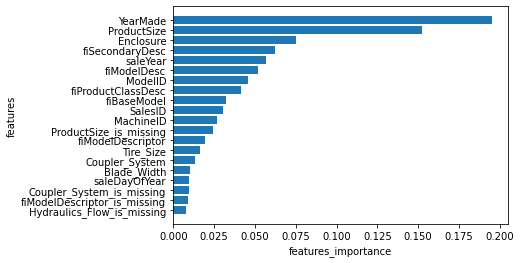

In [119]:
plot_features(X_train.columns, ideal_model.feature_importances_)

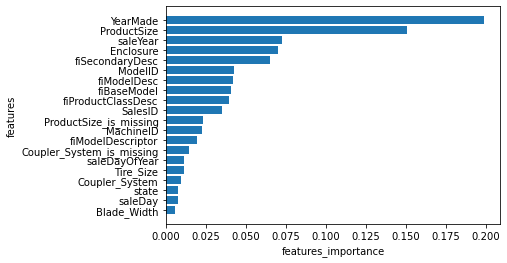

In [120]:
plot_features(X_train.columns, ideal_model_mine.feature_importances_)

In [121]:
df["Enclosure"].value_counts()

OROPS                  177971
EROPS                  141769
EROPS w AC              92601
EROPS AC                   18
NO ROPS                     3
None or Unspecified         2
Name: Enclosure, dtype: int64

**Question to finish:** Why might knowing the feature importances of a trained machine learning model be helpful?

**Final challenge/extension:** What other machine learning models could you try on our dataset? **Hint:** https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html check out the regression section of this map, or try to look at something like CatBoost.ai or XGBooost.ai.